In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [5]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1, color_codes=True, rc=None)

In [6]:
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = True

In [7]:
df = pd.read_excel('movie_info_final.xlsx')

In [8]:
df.columns

Index(['Unnamed: 0', '영화명', '감독', '제작사', '수입사', '배급사', '개봉일', '영화유형', '영화형태',
       '국적', '전국 스크린수', '전국 매출액', '전국 관객수', '서울 매출액', '서울 관객수', '장르', '등급',
       '영화구분', '개봉연도', 'score', 'name', 'pos_avg', 'neg_avg', 'pos_ratio',
       'std'],
      dtype='object')

In [9]:
df = df.loc[:,['전국 관객수','영화명','감독','배급사','국적','장르','등급','score','pos_avg','neg_avg','pos_ratio','std']]

In [10]:
df.head()

,전국 관객수,영화명,감독,배급사,국적,장르,등급,score,pos_avg,neg_avg,pos_ratio,std
0,"1,903,703",#살아있다,조일형,롯데컬처웍스(주)롯데엔터테인먼트,한국,드라마,15세이상관람가,4.638800,85.763121,-90.563520,0.336863,84.419190
1,"1,229,971",007 노 타임 투 다이,캐리 후쿠나가,유니버설픽쳐스인터내셔널 코리아(유),미국,액션,12세이상관람가,6.749669,87.680044,-87.565552,0.526364,88.654548
2,"870,451",1917,샘 멘데스,(주)스마일이엔티,미국,드라마,15세이상관람가,8.881600,88.066595,-81.116911,0.655702,81.632171
3,"2,963,449",26년,조근현,"(주)인벤트스톤,영화사청어람(주)",한국,액션,15세이상관람가,5.698400,85.926443,-87.330820,0.375600,85.181411
4,"12,811,206",7번방의 선물,이환경,(주)넥스트엔터테인먼트월드(NEW),한국,코미디,15세이상관람가,9.742800,95.018413,-77.215198,0.903800,51.811610


# Feature Engineering

# Y 변수 log 정규화

In [11]:
# 수치형 변수 int type으로 전환
df['audnum'] = df['전국 관객수'].str.replace(',', '').astype('int')

Text(0.5, 1.0, '원자료')

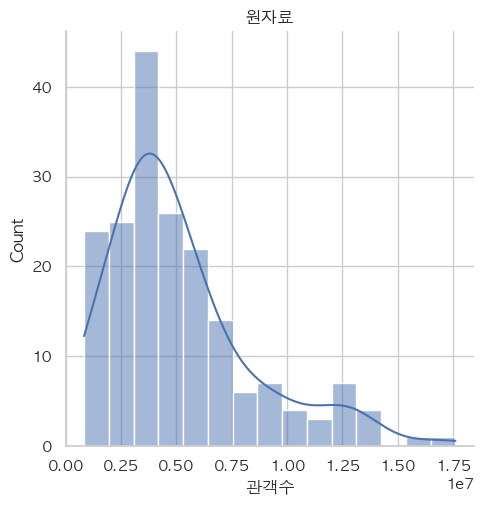

In [12]:
%matplotlib inline
fig = sns.displot(df['audnum'],kde=True)
plt.xlabel('관객수')
plt.ylabel('Count')
plt.title('원자료')


Text(0.5, 1.0, '로그변환 후')

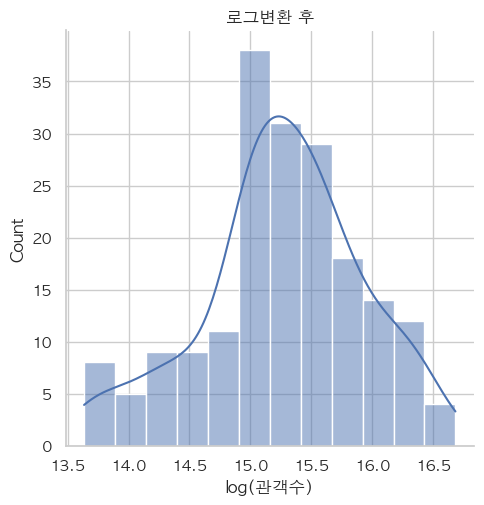

In [13]:
%matplotlib inline
# Target값 로그변환하여 정규분포화
fig = sns.displot(np.log(df['audnum']),kde=True)
plt.xlabel('log(관객수)')
plt.ylabel('Count')
plt.title('로그변환 후')


## 장르

In [14]:
df.groupby('장르').describe()['audnum'].sort_values('mean').columns

Index(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], dtype='object')

In [15]:
df.groupby('장르').describe()['audnum'].sort_values('mean', ascending=False).loc[:,['count', 'mean', 'std', 'min', 'max']]

,count,mean,std,min,max
장르,,,,,
판타지,3.0,7.466608e+06,5.403566e+06,1607082.0,12253247.0
전쟁,1.0,7.049643e+06,NaN,7049643.0,7049643.0
어드벤처,5.0,6.995106e+06,3.773813e+06,2818993.0,12552283.0
사극,12.0,6.360911e+06,4.622544e+06,1034866.0,17613682.0
SF,4.0,5.991362e+06,4.252715e+06,1549346.0,10273803.0
액션,70.0,5.350111e+06,2.931114e+06,1229971.0,13934592.0
드라마,32.0,4.916489e+06,3.537130e+06,859072.0,14245998.0
코미디,18.0,4.878583e+06,4.086789e+06,1209689.0,16264944.0
멜로/로맨스,4.0,4.705172e+06,1.585222e+06,2917213.0,6654837.0


In [16]:
sns.set_theme(context='notebook', style='darkgrid', palette='Spectral', font_scale=1, color_codes=True, rc=None)

In [275]:
# 장르 6개 class로 분류
genre_condition = [(df['장르'] == '사극'),
                   (df['장르'] == '애니메이션'),
                   ((df['장르'] == '전쟁')|(df['장르'] == '어드벤처')), 
                   ((df['장르'] == 'SF')|(df['장르'] == '판타지')),
                   ((df['장르'] == '공포(호러)')|(df['장르'] == '스릴러')|(df['장르'] == '미스터리'))]
                
genre_code = [1,2,3,4,5]
df['genre'] = np.select(genre_condition, genre_code).astype('str')

## 배급사

In [276]:
sum(df['배급사'].value_counts()[:4])

94

In [277]:
# 배급사 TOP4만 남기고 기타 처리
distributor_list = df['배급사'].value_counts()[:4]

def func(distributor):
    if distributor in distributor_list:
        return '대형'
    else:
        return '기타'

df['distributor'] = df['배급사'].apply(lambda x : func(x))

## 등급

In [278]:
df['등급'].value_counts()
df['rating'] = df['등급']

## 국적

In [279]:
df['국적'].value_counts()

한국    106
미국     80
일본      2
Name: 국적, dtype: int64

In [280]:
sns.set_theme(context='notebook', style='whitegrid', palette='Spectral', font_scale=1, color_codes=True, rc=None)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = True

[Text(0, 0, '106'), Text(0, 0, '80'), Text(0, 0, '2')]

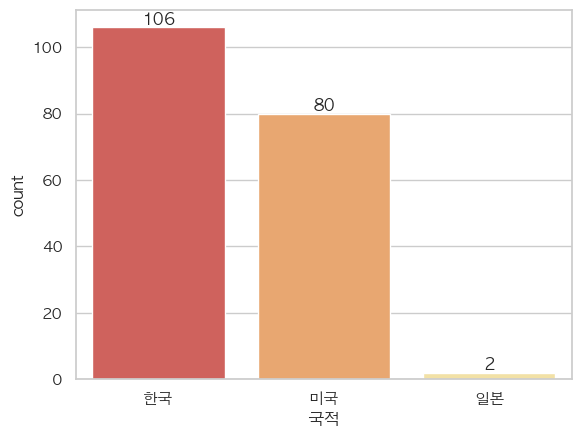

In [281]:
ax = sns.countplot(x = '국적', data = df, order = df['국적'].value_counts().index)

abs_values = df['국적'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

In [282]:
# 국내/해외 영화 구분
df['KR'] = np.where(df['국적'] == '한국', 1, 0)

In [283]:
df['KR'] = df['KR'].astype('object')
df['genre'] = df['genre'].astype('object')
df['rating'] = df['rating'].astype('object')
df['distributor'] = df['distributor'].astype('object')

In [284]:
# X_features = df.loc[:,['screenCnt', 'genre', 'distributor', 'rating', 'KR', 'weekend', 'release_month']]
X_features = df.loc[:,['genre','KR','distributor']]

In [285]:
X_features_ohe = pd.get_dummies(data = X_features, columns = ['genre','KR','distributor'])

In [286]:
log_y = np.log1p(df['audnum'])
y = df['audnum']

In [287]:
import pandas as pd
import statsmodels.formula.api as smf

model = smf.ols('log_y~ KR+distributor+score+pos_avg+std+pos_ratio', data=df)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_y   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     8.733
Date:                Thu, 15 Dec 2022   Prob (F-statistic):           2.34e-08
Time:                        09:32:13   Log-Likelihood:                -163.92
No. Observations:                 188   AIC:                             341.8
Df Residuals:                     181   BIC:                             364.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            26.3606      3.59

In [288]:
df.head()

,전국 관객수,영화명,감독,배급사,국적,장르,등급,score,pos_avg,neg_avg,pos_ratio,std,audnum,genre,distributor,rating,KR
0,"1,903,703",#살아있다,조일형,롯데컬처웍스(주)롯데엔터테인먼트,한국,드라마,15세이상관람가,4.638800,85.763121,-90.563520,0.336863,84.419190,1903703,0,기타,15세이상관람가,1
1,"1,229,971",007 노 타임 투 다이,캐리 후쿠나가,유니버설픽쳐스인터내셔널 코리아(유),미국,액션,12세이상관람가,6.749669,87.680044,-87.565552,0.526364,88.654548,1229971,0,기타,12세이상관람가,0
2,"870,451",1917,샘 멘데스,(주)스마일이엔티,미국,드라마,15세이상관람가,8.881600,88.066595,-81.116911,0.655702,81.632171,870451,0,기타,15세이상관람가,0
3,"2,963,449",26년,조근현,"(주)인벤트스톤,영화사청어람(주)",한국,액션,15세이상관람가,5.698400,85.926443,-87.330820,0.375600,85.181411,2963449,0,기타,15세이상관람가,1
4,"12,811,206",7번방의 선물,이환경,(주)넥스트엔터테인먼트월드(NEW),한국,코미디,15세이상관람가,9.742800,95.018413,-77.215198,0.903800,51.811610,12811206,0,대형,15세이상관람가,1


In [289]:
X_feat_lst = ['score','pos_avg','std']

In [290]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
result = scaler.fit_transform(df.loc[:,X_feat_lst])

data_scaled = pd.DataFrame(result, columns=X_feat_lst)

In [291]:
X_features_fin = pd.concat([X_features_ohe, data_scaled],axis=1)

In [292]:
data2 = pd.concat([X_features_fin, log_y], axis=1)

In [293]:
import warnings
warnings.filterwarnings('ignore')

In [294]:
data2.to_excel('data2.xlsx', index=False)

In [295]:
#log y
data2 = pd.read_excel('data2.xlsx')
X = data2.iloc[:,1:-1]
y = data2.iloc[:,-1]

In [296]:
X

,genre_1,genre_2,genre_3,genre_4,genre_5,KR_0,KR_1,distributor_기타,distributor_대형,score,pos_avg,std
0,0,0,0,0,0,0,1,1,0,-3.318231,-2.176046,0.703368
1,0,0,0,0,0,1,0,1,0,-1.368458,-1.322455,1.171274
2,0,0,0,0,0,1,0,1,0,0.600769,-1.150326,0.395469
3,0,0,0,0,0,0,1,1,0,-2.339497,-2.103320,0.787575
4,0,0,0,0,0,0,1,0,1,1.396244,1.945266,-2.898988
...,...,...,...,...,...,...,...,...,...,...,...,...
183,0,0,1,0,0,1,0,1,0,0.195088,-0.177043,0.686431
184,0,0,0,0,0,1,0,1,0,0.514497,-0.048984,-0.154420
185,1,0,0,0,0,0,1,1,0,-1.158161,-0.850509,1.235833
186,0,0,0,0,0,0,1,0,1,-0.135960,1.117082,0.111696


In [297]:
data2.head()

,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,KR_0,KR_1,distributor_기타,distributor_대형,score,pos_avg,std,audnum
0,1,0,0,0,0,0,0,1,1,0,-3.318231,-2.176046,0.703368,14.459312
1,1,0,0,0,0,0,1,0,1,0,-1.368458,-1.322455,1.171274,14.022502
2,1,0,0,0,0,0,1,0,1,0,0.600769,-1.150326,0.395469,13.676768
3,1,0,0,0,0,0,0,1,1,0,-2.339497,-2.103320,0.787575,14.901865
4,1,0,0,0,0,0,0,1,0,1,1.396244,1.945266,-2.898988,16.365831


In [298]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
result = pca.fit_transform(X)

PCA_Z = pd.DataFrame(result, columns=["z1"])
PCA_Z

,z1
0,3.587533
1,2.216793
2,0.531671
3,3.034708
4,-3.606455
...,...
183,0.388713
184,-0.362218
185,1.923341
186,-0.483545


## Linear Regression

In [299]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [300]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE: %0.3f" %(rmse))

RMSE: 0.564


In [301]:
# evaluate_regr(y_test, y_pred)

<AxesSubplot:ylabel='audnum'>

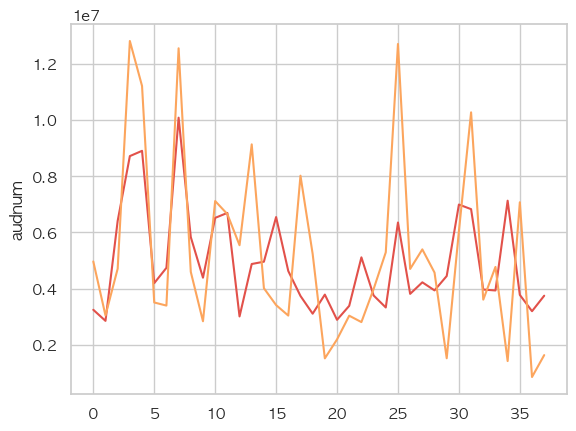

In [302]:
sns.lineplot(x = range(38), y = np.exp(y_pred))
sns.lineplot(x = range(38), y = np.exp(y_test))

### Cross validation

In [303]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)

In [304]:
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X, y, scoring='neg_mean_squared_error', cv=cv)

In [305]:
rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse, 3))
print('RMSE 평균: %0.3f' %(rmse.mean()))

RMSE: [0.564 0.473 0.62  0.565 0.733]
RMSE 평균: 0.591


### PCA

In [306]:
X_train, X_test, y_train, y_test = train_test_split(PCA_Z, y, test_size = 0.2, random_state=123)

In [307]:
lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, PCA_Z, y, scoring='neg_mean_squared_error', cv=cv)

In [308]:
rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse, 3))
print('RMSE 평균: %0.3f' %(rmse.mean()))

RMSE: [0.621 0.561 0.617 0.568 0.792]
RMSE 평균: 0.632


In [262]:
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE: %0.3f" %(rmse))

RMSE: 0.621


<AxesSubplot:ylabel='audnum'>

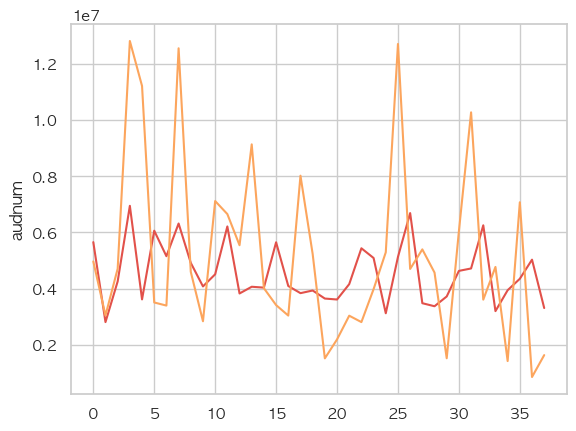

In [263]:
sns.lineplot(x = range(38), y = np.exp(y_pred))
sns.lineplot(x = range(38), y = np.exp(y_test))

### Regularization

In [264]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

### 1) Ridge

In [265]:
ridge_model = Ridge()

ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}
data_scaled
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,
                                     param_grid=ridge_params,
                                     scoring='neg_mean_squared_error',
                                     cv=5)

gridsearch_ridge_model.fit(X_train, y_train)
print('최적 하이퍼파라미터:', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터: {'alpha': 4, 'max_iter': 3000}


In [266]:
ridge_model = Ridge(max_iter=3000, alpha=3)
ridge_scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=cv)

In [267]:
ridge_rmse = np.sqrt(-ridge_scores)
print('RMSE:', np.round(ridge_rmse, 3))
print('RMSE 평균: %0.3f' %(ridge_rmse.mean()))

RMSE: [0.548 0.45  0.602 0.541 0.706]
RMSE 평균: 0.569


In [268]:
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

<AxesSubplot:ylabel='audnum'>

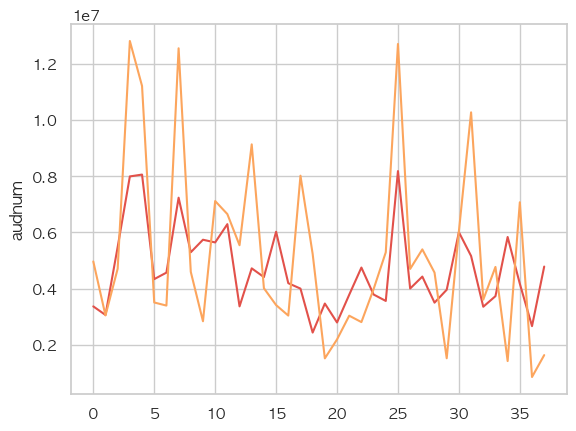

In [269]:
sns.lineplot(x = range(38), y = np.exp(y_pred))
sns.lineplot(x = range(38), y = np.exp(y_test))

### 2) Lasso

In [270]:
lasso_model = Lasso()

lasso_alpha = 1/np.array([1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}

gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                     param_grid=lasso_params,
                                     scoring='neg_mean_squared_error',
                                     cv=5)

gridsearch_lasso_model.fit(X_train, y_train)
print('최적 하이퍼파라미터:', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터: {'alpha': 0.001, 'max_iter': 3000}


In [271]:
lasso_model = Lasso(max_iter=3000, alpha=1/1000)
lasso_scores = cross_val_score(lasso_model, X, y, scoring='neg_mean_squared_error', cv=cv)

In [272]:
lasso_rmse = np.sqrt(-lasso_scores)
print('RMSE:', np.round(lasso_rmse, 3))
print('RMSE 평균: %0.3f' %(lasso_rmse.mean()))

RMSE: [0.542 0.449 0.61  0.555 0.696]
RMSE 평균: 0.570


In [273]:
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.001, max_iter=3000)

In [81]:
y_pred = lasso_model.predict(X_test)

In [82]:
sns.set_theme(context='notebook', style='whitegrid', palette='Spectral', font_scale=1, color_codes=True, rc=None)

<AxesSubplot:ylabel='audnum'>

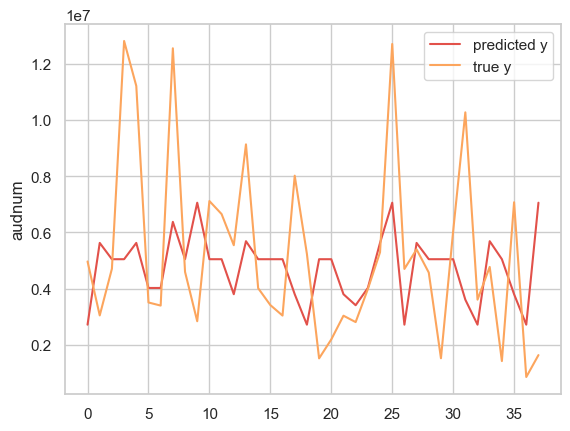

In [83]:
sns.lineplot(x = range(38), y = np.exp(y_pred),label='predicted y')
sns.lineplot(x = range(38), y = np.exp(y_test),label='true y')


In [84]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("RMSE: %0.3f" %(rmse))

RMSE: 0.658


Text(0.5, 1.0, '규제 후 회귀 계수 시각화')

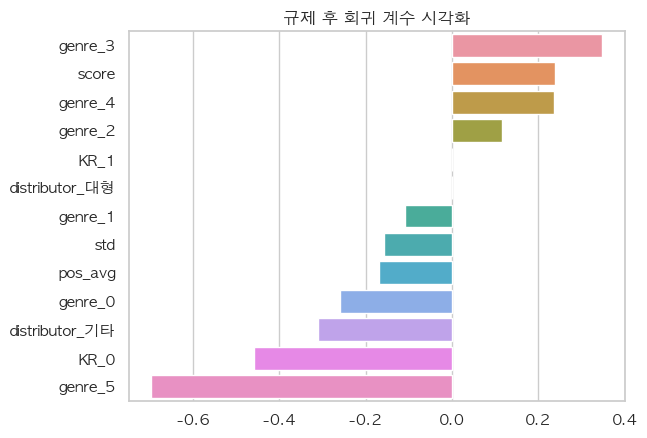

In [1617]:
import seaborn as sns
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

coef = pd.Series(lasso_model.coef_, index = X.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.title('규제 후 회귀 계수 시각화')

## Random Forest

In [1543]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [1544]:
rf = RandomForestRegressor(n_estimators=100, random_state=123, max_depth=1, n_jobs=-1)
rf_scores = cross_val_score(rf, X, y, scoring='neg_mean_squared_error', cv=cv)

In [1545]:
rf_rmse = np.sqrt(-rf_scores)
print('RMSE:', np.round(rf_rmse, 3))
print('RMSE 평균: %0.3f' %(rf_rmse.mean()))

RMSE: [0.61  0.554 0.611 0.57  0.829]
RMSE 평균: 0.635


In [1546]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=1, n_jobs=-1, random_state=123)

In [1547]:
y_pred = rf.predict(X_test)

<AxesSubplot:ylabel='audnum'>

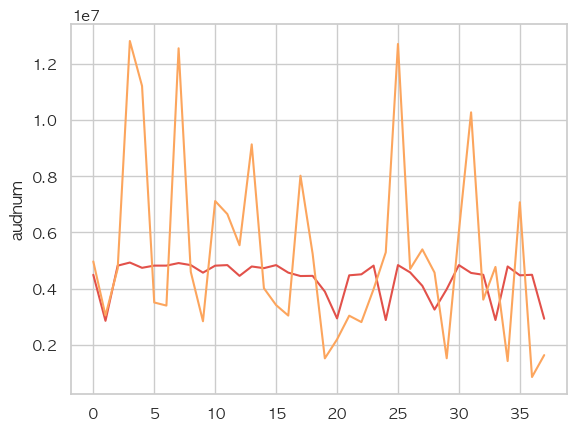

In [1548]:
sns.lineplot(x = range(38), y = np.exp(y_pred))
sns.lineplot(x = range(38), y = np.exp(y_test))

### Parameter tuning

In [1549]:
rf_model = RandomForestRegressor()
rf_params = {'random_state':[123], 'n_estimators':[200,300,500], 'max_depth':[2,3,4,5]}
#rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
gridsearch_rf_model = GridSearchCV(estimator=rf_model,
                                   param_grid=rf_params,
                                   scoring='neg_mean_squared_error',
                                   cv=5)

gridsearch_rf_model.fit(X_train, y_train)
print('최적 하이퍼파라미터:', gridsearch_rf_model.best_params_)

최적 하이퍼파라미터: {'max_depth': 5, 'n_estimators': 500, 'random_state': 123}


In [1559]:
rf_grid = RandomForestRegressor(n_estimators=500, random_state=123, max_depth=5, n_jobs=-1)
rf_grid_scores = cross_val_score(rf_grid, X, y, scoring='neg_mean_squared_error', cv=cv)

In [1560]:
rf_grid_rmse = np.sqrt(-rf_grid_scores)
print('RMSE:', np.round(rf_grid_rmse, 3))
print('RMSE 평균: %0.3f' %(rf_grid_rmse.mean()))

RMSE: [0.554 0.52  0.577 0.538 0.758]
RMSE 평균: 0.590


## XGBoost

In [1551]:
from xgboost import XGBRegressor

In [1552]:
import xgboost as xgb
xgb.set_config(verbosity=0)

In [1553]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=123)

In [1554]:
xg_model = XGBRegressor()
xg_params = {'random_state':[123], 
              'learning_rate':[0.03,0.05,0.07],
              'n_estimators':[100,120,150,200],
            'max_depth':[2,4,6]}
gridsearch_xg_model = GridSearchCV(estimator=xg_model,
                                   param_grid=xg_params,
                                   scoring='neg_mean_squared_error',
                                   cv=5)

gridsearch_xg_model.fit(X_train, y_train)
print('최적 하이퍼파라미터:', gridsearch_xg_model.best_params_)

최적 하이퍼파라미터: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 200, 'random_state': 123}


In [1555]:
xg_reg = XGBRegressor(booster='gbtree',objective='reg:squarederror',
                     max_depth=2,learning_rate=0.05,n_estimators=200,
                     n_jobs=-1)
xg_scores = cross_val_score(xg_reg, X, y, scoring='neg_mean_squared_error', cv=cv)

In [1556]:
xg_rmse = np.sqrt(-xg_scores)
print('RMSE:', np.round(xg_rmse, 3))
print('RMSE 평균: %0.3f' %(xg_rmse.mean()))

RMSE: [0.576 0.513 0.584 0.536 0.75 ]
RMSE 평균: 0.592


In [1557]:
xg_reg.fit(X_train, y_train)

y_pred = xg_reg.predict(X_test)

<AxesSubplot:ylabel='audnum'>

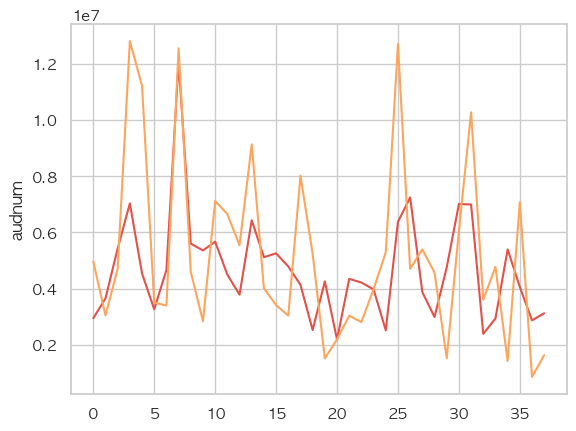

In [1558]:
sns.lineplot(x = range(38), y = np.exp(y_pred))
sns.lineplot(x = range(38), y = np.exp(y_test))